In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
#!unrar x '/content/drive/MyDrive/data.rar'

## Imports

In [3]:
%matplotlib inline
import numpy as np
import math
import matplotlib
import matplotlib.image as image
import matplotlib.pyplot as plt
from PIL import Image
from scipy.cluster.vq import kmeans, vq
import scipy.spatial.distance as distance
import os
import glob
import pickle
import pandas as pd
import cv2
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from os.path import exists as file_exists
from sklearn.multiclass import OneVsRestClassifier
plt.style.use('seaborn')

## Get_Image_Paths

In [4]:
def get_image_paths(data_path, categories): # path to data and Categories are Classes of data
    train_image_paths, train_labels = [], [] 
    for cat in categories: # Loop over each train category folder and extract path
        imgs = glob.glob(data_path+'train/'+cat+'/*.*')
        train_image_paths = train_image_paths + imgs # Saving each path in train_image_paths
        train_labels = train_labels + [cat]*len(imgs) # Assigning label to each image as class it belong

    test_image_paths, test_labels = [], []
    for cat in os.listdir(data_path+'test/'):# Loop over each test category folder and extract path
        imgs = glob.glob(data_path+'test/'+cat+'/*.*')
        test_image_paths = test_image_paths + imgs # Saving each path in test_image_paths
        test_labels = test_labels + [cat]*len(imgs) # Assigning label to each image as class it belong

    return np.array(train_image_paths), np.array(test_image_paths), np.array(train_labels),np.array(test_labels)

## Build_Vocabulary


In [5]:
def build_vocabulary(image_paths, vocab_size,features):
    BOG = [] # List for bag of features
    print("Extract SIFT features")
    sift = cv2.xfeatures2d.SIFT_create() # specify how many maximum descriptors you want in the output 
    for path in image_paths: # Loop over all images
        img = Image.open(path) # reading image
        key_points, descriptors = sift.detectAndCompute(np.array(img), None) # Extracting keypoints and descriptors from the each image Using SIFT
        BOG.append(descriptors)
    # concatenating all features and converting to them float
    BOG = np.concatenate(BOG, axis=0).astype('float32')
    print("The size of Bag of features:",len(BOG))
    # Kmeans to quantize the features with cluster size = vocab_size
    vocab,_=kmeans(BOG,vocab_size,1)
  
    return vocab

## Get_Bags_Of_SIFT

In [6]:
def get_bags_of_sifts(image_path,vocab_name,features):
   sift = cv2.xfeatures2d.SIFT_create() #specify how many maximum descriptors you want 
   with open(vocab_name, "rb") as vf: # Load the vocabulary using pickle
        vocab = pickle.load(vf)
        im,vo=len(image_path),len(vocab) # Length of image_path and vocab
        image_feats = np.zeros((im,vo)) # create image_feats of size (image_path,vocab)
   k=0
   for path in image_path:# Loop over all images
        img = Image.open(path) 
        keypoints, descriptors = sift.detectAndCompute(np.array(img), None)
        dist_ = np.linalg.norm(vocab-descriptors) # Find the Eculidean Distance
        Min_dist = np.argmin(dist_, axis=0) # Find the minimum distance
        for v in Min_dist: # Collecting vote for each minimum distance
            image_feats[k,v] += 1
        k=k+1
   return image_feats

## Nearest_Neighbor_Classify

In [8]:
def nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,optimal_k):
    predictions = []
    Cal_dis= []
    predicted_categories = []
    # Converting train and test image _feats into numpy array
    train_image_feats,test_image_feats = np.array(train_image_feats),np.array(test_image_feats)
    for t in test_image_feats:# Loop over all the test_image_feats 
        for tr in train_image_feats: # Loop over all train_image_feats
            Cal_dis.append(np.sum((t-tr)**2)**(1/2)) # Calculate distance of single test_image_feat to all training samples
        for k in range(optimal_k): # Loop over the all given opimal K value
            minD= np.argmin(Cal_dis) # Finding the index with min value at each iteration
            predictions.append(train_labels[minD]) # append it into list
            Cal_dis[minD] = 67000000000 # Changing the currently selected index value to 67000 so it could not be select again
        labels,counts = np.unique(predictions,return_counts = True) # Unique Lables with their counts
        predicted_categories.append(labels[np.argmax(counts)]) # Select label with majority class or label
        predictions = [] # Setting it [] next values of test_image_feats could not add into it.
        Cal_dis = []
       
    return predicted_categories
    

### Selecting optimal value of K for KNN

In [7]:
def optimalKNN(train_image_feats, train_labels, test_image_feats,test_labels,k):
        Errors = []
        for i in range(1,k):# Loop over Given the range of k
                knn = KNeighborsClassifier(n_neighbors=i) 
                knn.fit(train_image_feats, train_labels)# Fit the nearest Neighbour model
                pred= knn.predict(test_image_feats) # Predict the reults
                Errors.append(np.mean(pred!= test_labels)) # Find the error between predicted and true_lables
        Errors= np.around(np.array(Errors),2) # Rounding up all errors
        min_k=np.where(Errors==Errors.min())# Selecting the  min index of the array
        if(isinstance(min_k,tuple)):# Check If return index is tuple or list 
                                
            min_k=(min_k[0])[0] #select first one because all indexes will be having same values
        else:
            min_k=min_k[0] # otherwise single value
        plt.figure(figsize=(10,6)) # plot the Graph of error rate for each K value
        plt.plot(range(1,k),Errors,color='blue', linestyle= 'dashed', marker='o',
        markerfacecolor= 'red', markersize=10)
        plt.title('Error_Rate vs # of K')
        plt.xlabel('K')
        plt.ylabel('Error_Rate')
        plt.show()
        return min_k # return min value of K to pass in nearest_neighbor_Classifier


## SVM_Classify

In [9]:
def svm_classify(train_image_feats, train_labels, test_image_feats):
    """random_state = np.random.RandomState(0)
    classifier = OneVsRestClassifier(svm.SVC(kernel="linear", probability=True, random_state=random_state))
    classifier.fit(train_image_feats, train_labels)
    pred=classifier.predict(test_image_feats)
    print(pred)
    return pred"""
    svc = svm.SVC(random_state=0)
    param_C = [0.001 , 0.01 , 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0] # Different C parameters
    param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] # Different gamma Paramters
    param_grid = [{'C': param_C, 'gamma': param_gamma,'kernel': ['linear']}] # Linear CLassifier 
    GSC = GridSearchCV(estimator = svc, param_grid= param_grid, scoring='accuracy',) # GridSearchCV for paramter tuning
    GSC = GSC.fit(train_image_feats, train_labels) # Fitting data in GSC  
    classify = GSC.best_estimator_
    classify.fit(train_image_feats, train_labels)# Fitting data in model
    pred = classify.predict(test_image_feats) #Predictions
    return pred 

## Visualization

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=True, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true,y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print()
    print(cm)

    fig, ax = plt.subplots(figsize=(10,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def perf_measure(y_actual, y_hat):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
            TP += 1
        elif y_hat[i]==1 and y_actual[i]!=y_hat[i]:
            FP += 1
        elif y_actual[i]==y_hat[i]==0:
            TN += 1
        elif y_hat[i]==0 and y_actual[i]!=y_hat[i]:
            FN += 1

    return [TP, FP, TN, FN]


def display_results(test_labels, categories, predicted_categories,normalize=False):
    df = pd.DataFrame(columns= ['Category']+list(categories))

    cols = ['Category']+['TP', 'FP', 'TN', 'FN']
    df = pd.DataFrame(columns= cols)
    for el in categories:
        temp_y_test = (test_labels == el).astype(int)
        temp_preds = (predicted_categories == el).astype(int)
        row = [el]+ perf_measure(temp_y_test, temp_preds)
        df = df.append(pd.Series(row, index=cols), ignore_index=True)
    print(df, '\n\n')

    for i in range(len(categories)):
        test_labels[test_labels==categories[i]] = i
        predicted_categories[predicted_categories==categories[i]] = i
    test_labels, predicted_categories = test_labels.astype(int), predicted_categories.astype(int)
    class_names=np.array(categories)
    plot_confusion_matrix(test_labels, predicted_categories,classes=class_names,normalize=False)
    plt.show()
    
    acc = accuracy_score(y_pred=predicted_categories, y_true=test_labels) #you need to put your own array names here
    print('Accuracy: ', acc)
    
    return
 

## Main Function to run file:
#### 1- Specify the Data path
#### 2- Specify the name of Classifier
#### 3- Specify Total features to extract
#### 4- Specify the  vocabulary size
#### 5- Specify the Name of vocabulary


In [23]:
def Main(data_path,categories,features,vocab_size,vocab_name,CLASSIFIER,Visualization=False,normalize=False):
            print('Getting paths and labels for all train and test data\n')
            train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories)
            print("The Training Data:",len(train_image_paths),len(train_labels))
            print("The Testing Data:",len(test_image_paths),len(test_labels))
            print('===============================================================================')
            print("Using SIFT representation for images.")
            print('===============================================================================')
            # Check if vocab exist if not make one
            if(not file_exists(vocab_name)):
                    print('No existing visual word vocabulary found. Computing one from training images\n')
                    vocab = build_vocabulary(train_image_paths, vocab_size,features)
                    file = open(vocab_name, "wb")
                    pickle.dump(vocab,file, protocol=pickle.HIGHEST_PROTOCOL)
                    file.close()
                 
            # Get Train images histograms   
            train_image_feats = get_bags_of_sifts(train_image_paths,vocab_name,features)
            tfile = open('train.pkl', "wb")
            # Making pickle file for faster work
            pickle.dump(train_image_feats,tfile, protocol=pickle.HIGHEST_PROTOCOL)
            tfile.close()
            # Get Train images histograms 
            test_image_feats = get_bags_of_sifts(test_image_paths,vocab_name,features)
            print("SIFT Features:")
            print("Training Data Shape:",train_image_feats.shape,train_labels.shape)
            print("Testing Data Shape:",test_image_feats.shape,test_labels.shape)
            if(CLASSIFIER == 'nearest neighbor'):
                # Code nearest_neighbor_classify function above 
                k=optimalKNN(train_image_feats, train_labels, test_image_feats,test_labels,vocab_size)
                print("Selecting optimal K for KNN:",k)               
                predicted_categories = nearest_neighbor_classify(train_image_feats, train_labels, test_image_feats,k)               
                predicted_categories=np.array( predicted_categories)

            elif(CLASSIFIER == 'support vector machine'):
                # Code svm_classify function above
                predicted_categories = svm_classify(train_image_feats, train_labels, test_image_feats)
                predicted_categories=np.array( predicted_categories)
            else:
                print("Not Classifier")
            if Visualization:
                print('===============================================================================')
                display_results(test_labels, categories, predicted_categories,normalize=False)
            return train_labels,train_image_feats,test_image_feats,test_labels,predicted_categories


In [12]:
!pip uninstall opencv-python

In [13]:
!pip install opencv-contrib-python==3.4.2.17

Getting paths and labels for all train and test data

The Training Data: 1500 1500
The Testing Data: 705 705
Using SIFT representation for images.
SIFT Features:
Training Data Shape: (1500, 900) (1500,)
Testing Data Shape: (705, 900) (705,)
Best Training Score = 0.546 with parameters {'C': 0.001, 'gamma': 1e-05, 'kernel': 'linear'}
        Category   TP  FP   TN  FN
0        Kitchen    0   8  697   0
1          Store    0   2  703   0
2        Bedroom   69   6  583  47
3     LivingRoom    0  10  695   0
4         Office    0   7  698   0
5     Industrial    0   5  700   0
6         Suburb    0   0  705   0
7     InsideCity    0   1  704   0
8   TallBuilding    0   3  702   0
9         Street    0   6  699   0
10       Highway   67  21  583  34
11   OpenCountry    0  43  662   0
12         Coast  209  25  420  51
13      Mountain    0  28  677   0
14        Forest  191   4  473  37 


Confusion matrix, without normalization

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [ 

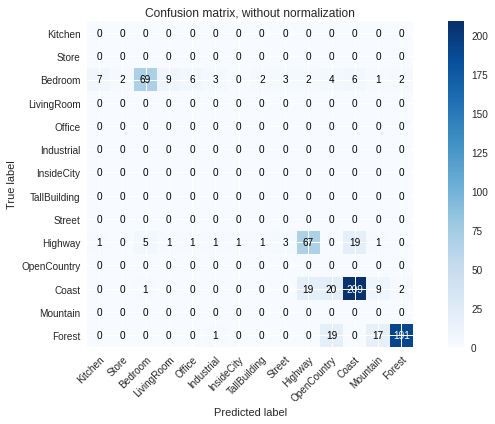

Accuracy:  0.7602836879432624


In [24]:
CLASSIFIER = 'support vector machine'
data_path = '/content/data/'
categories = np.array(['Kitchen', 'Store', 'Bedroom', 'LivingRoom', 'Office',
                          'Industrial', 'Suburb', 'InsideCity', 'TallBuilding', 'Street',
                          'Highway', 'OpenCountry', 'Coast', 'Mountain', 'Forest'])
features=0
vocab_size=900
vocab_name='expsvm0v900.pkl'
train_labels,train_image_feats,test_image_feats,test_lables,predictions=Main(data_path,categories,features,vocab_size,vocab_name,CLASSIFIER,Visualization=True,normalize=True)

## Predcitions for Single Image


### KNN predcitions

In [28]:
train_image_paths, test_image_paths, train_labels, test_labels = get_image_paths(data_path, categories)

In [25]:
def KNNpredictions(image,vocab_name,test_labels,train_labels,):
    image_feats,keypoints=read_imagefeats(image,vocab_name) # Function to convert a single image into histogram
    k,optimal_k=0,400
    predictions,Cal_dis=[],[]
    for i in train_image_feats:
      Cal_dis.append(np.sum((image_feats-i)**2)**(1/2)) # Calculating distnace of single image iwth entire training set
    for k in range(optimal_k):
      index_min= np.argmin(Cal_dis)
      predictions.append(train_labels[index_min])
      Cal_dis[index_min] = 67000000000
    labels,counts = np.unique(predictions,return_counts = True)
    predicted_categories=labels[np.argmax(counts)]
    return predicted_categories,keypoints # Returning keypoint and predictions from the KNN

#### Read_Imagefeats

In [26]:
def read_imagefeats(image,vocab_name):
    k=0
    sift = cv2.xfeatures2d.SIFT_create() #specify how many maximum descriptors you want in the output 
    with open(vocab_name, "rb") as vocab_file:
          vocab = pickle.load(vocab_file)
          image_feats = np.zeros((len(image),len(vocab))) # Creating image_feats matrix with size of (image,vocab)
    img = Image.open(image)
    keypoints, bag_of_features = sift.detectAndCompute(np.array(img), None)
    dist_ = distance.cdist(vocab,bag_of_features, 'euclidean')
    Min_dist = np.argmin(dist_, axis=0)
    for vote in Min_dist:
          image_feats[k,vote] += 1
    return image_feats,keypoints # Extracting keypoints and descriptors for a single image and returning image_feats

### SVMPredcitions

In [27]:
def SVMpredictions(train_image_feats,train_labels,test_image_feats,vocab_name):
    svc = svm.SVC(random_state=0)
    param_C = [0.001 , 0.01 , 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0] # Different C parameters
    param_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0] # Different gamma Paramters
    param_grid = [{'C': param_C, 'gamma': param_gamma,'kernel': ['linear']}] # Linear CLassifier 
    GSC = GridSearchCV(estimator = svc, param_grid= param_grid, scoring='accuracy',) # GridSearchCV for paramter tuning
    GSC = GSC.fit(train_image_feats, train_labels) # Fitting data in GSC  
    classify = GSC.best_estimator_
    classify.fit(train_image_feats, train_labels)
    image_feats,keypoint=read_imagefeats(test_image_feats,vocab_name)
    pred_label = classify.predict(image_feats)
    return pred_label,keypoint

In [31]:
def plot_predic(num,vocab_name,algo="SVM"): 
      if (algo == "KNN"):  
           # For KNN predictiosn   
           pred,keypoints=KNNpredictions(test_image_paths[num],vocab_name,test_lables[num],train_labels)
      else:
           # For SVM predictions
           pred,keypoints=SVMpredictions(train_image_feats,train_labels,test_image_paths[num],vocab_name)
      print("Predictions:",pred[0])
      print()
      x = keypoints[0].pt[0]
      y = keypoints[0].pt[1]
      vec=[x,y]
      mag=np.linalg.norm(vec)
      direct=(np.rad2deg(np.arctan2(y,x))) + 180
      im=cv2.imread(test_image_paths[num])
      im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB )
      fig, ax = plt.subplots(1,2,figsize=(10,5))
      pts = cv2.KeyPoint_convert(keypoints)
      ax[0].imshow(im)
      ax[0].set_title(test_labels[num])
      ax[1].hist(direct, bins=10) #calculating histogram
      ax[1].set_title("Histogram of a Keypoint")
      plt.show()


Predictions: Highway



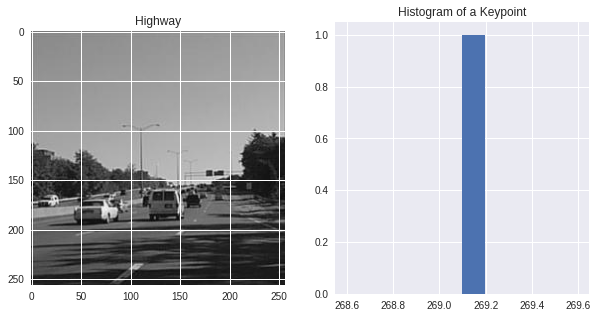

In [32]:
# Give any index of image from test 
# Give name of algo you want to make predictions for SVM use (svm) and for KNN use (KNN) 
plot_predic(302,vocab_name,algo="svm")  

### TP, FP, NP results Visualization 

In [36]:
def PredictionsGraph(image_path,test_labels,predicted_categories,Classname):
    def get_index(predicted_categories):
        TP, FP, TN, FN = [],[],[],[]
        y_test=(test_labels == Classname).astype(int) # Collecting results for test labels for a single class
        y_pred=(predicted_categories == Classname).astype(int) # Collecting predcitions for a single class
        for i in range(len(y_pred)):
              if y_pred[i]==y_test[i]==1:
                  TP.append(i) # append all TP index
              elif (y_pred[i]==1) and (y_test[i]!=y_pred[i]):
                  FP.append(i) # append FP index
              elif y_pred[i]==y_test[i]==0:
                  TN.append(i) # append all TN index
              elif (y_pred[i]==0) and (y_test[i]!=y_pred[i]):
                  FN.append(i) # apend all FN index
        return TP, FP, TN, FN
    def read_image(image):
      im=cv2.imread(image)
      return cv2.cvtColor(im, cv2.COLOR_BGR2RGB )
    TP, FP, TN, FN=get_index(np.array(predicted_categories))
    fig, ax = plt.subplots(1,4,figsize=(15,10))
    test_labels=list(test_labels)
    ax[0].imshow(read_image(image_path[test_labels.index(Classname)]))  
    ax[0].set_title('Sample Image') 
    ax[1].imshow(read_image(image_path[TP[3]])) 
    ax[1].set_title('True Positive')
    ax[2].imshow(read_image(image_path[FN[0]]))
    ax[2].set_title('False Negative')
    ax[3].imshow(read_image(image_path[FP[3]])) 
    ax[3].set_title('False Positive')

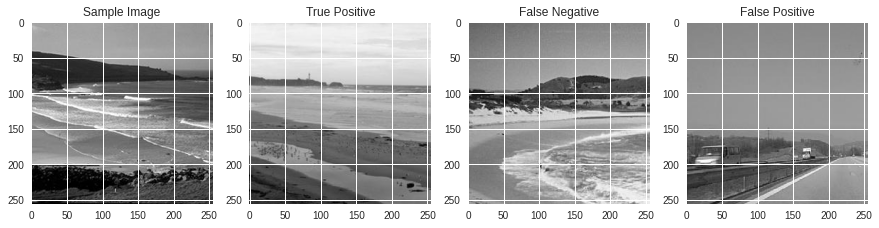

In [37]:
Classname='12' # Class number
PredictionsGraph(test_image_paths,test_lables,predictions,Classname)
